In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read the data and show basic statistics

In [3]:
df = pd.read_csv("data/data_live.csv")
columns = ["price", "volume", "trade_ts"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"

df = df[columns]
df["trade_ts"] = df["trade_ts"].apply(lambda x: datetime.strptime(x, timestamp_format))
df = df.set_index("trade_ts")

# Group by seconds and apply different aggregation functions
df_grouped = df.groupby(pd.Grouper(freq="s")).agg({
    "price": "mean",  
    "volume": "sum" 
})
df_grouped["price"] = df_grouped["price"].interpolate(method="linear")
# Describe the grouped data
description = df_grouped.describe()
print(description)


               price       volume
count    3017.000000  3017.000000
mean   101088.735678     0.037688
std        84.742929     0.108178
min    100895.530000     0.000000
25%    101012.450000     0.001140
50%    101115.230000     0.006580
75%    101151.676667     0.039180
max    101259.245000     2.395850


# Visualization
## Line Plot for prices & histogram for volume

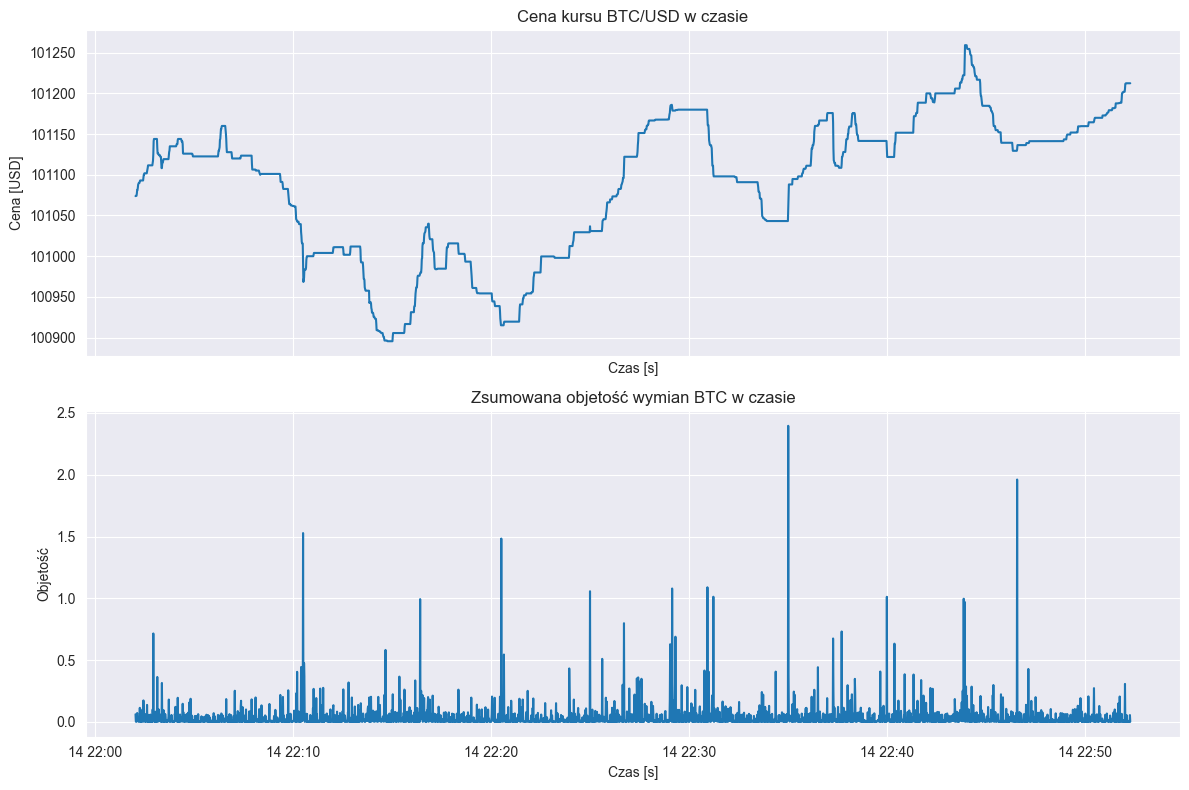

In [4]:
# Plot Price and Volume
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Price
ax[0].plot(df_grouped.index, df_grouped["price"], label="Price", linewidth=1.5)
ax[0].set_title("Cena kursu BTC/USD w czasie")
ax[0].set_ylabel("Cena [USD]")
ax[0].set_xlabel("Czas [s]")
ax[0].grid(True)
# ax[0].legend()

# Plot Volume
ax[1].plot(df_grouped.index, df_grouped["volume"], label="Volume")
ax[1].set_title("Zsumowana objetość wymian BTC w czasie")
ax[1].set_ylabel("Objetość")
ax[1].set_xlabel("Czas [s]")
ax[1].grid(True)
# ax[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Autocorrelation Plot

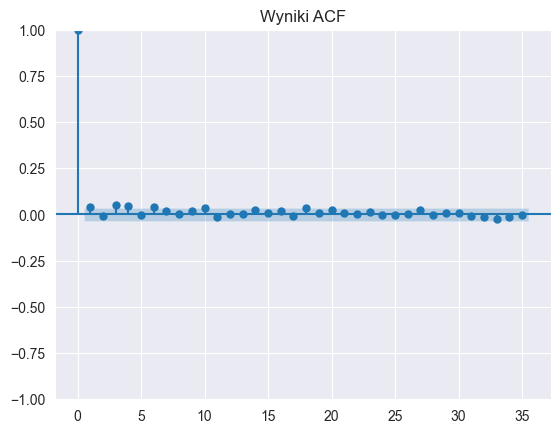

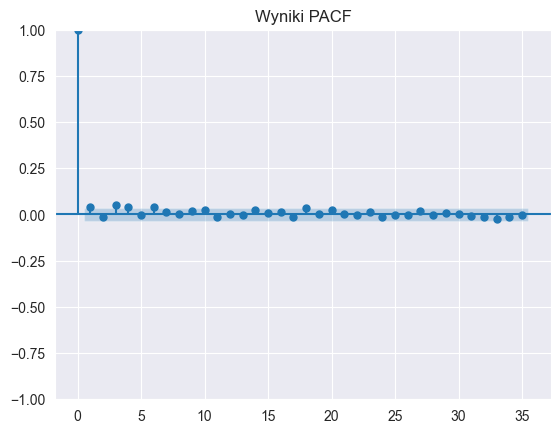

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Autokorelacja
plot_acf(df_grouped["volume"])
plt.title("Wyniki ACF")
plt.show()

# Parcjalna autokorelacja
plot_pacf(df_grouped['volume'])
plt.title("Wyniki PACF")
plt.show()

1. This plot does not show any recurring peaks or cycles, so the series is likely non-periodic.
2. 

In [6]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("Odrzucamy hipotezę zerową: dane są stacjonarne")
    else:
        print("Nie odrzucamy hipotezy zerowej: dane nie są stacjonarne")

adf_test(df_grouped["volume"])

ADF Statistic: -20.428212328266657
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4325236578059055), '5%': np.float64(-2.8625003821301203), '10%': np.float64(-2.5672812364372812)}
Odrzucamy hipotezę zerową: dane są stacjonarne


<p>p-value is greater than 0.05 so the null hypothesis cannot be rejected, and the time series is considered <b>non-stationary</b></p>


# Decomposition so Trend, Seasonality and Residuals

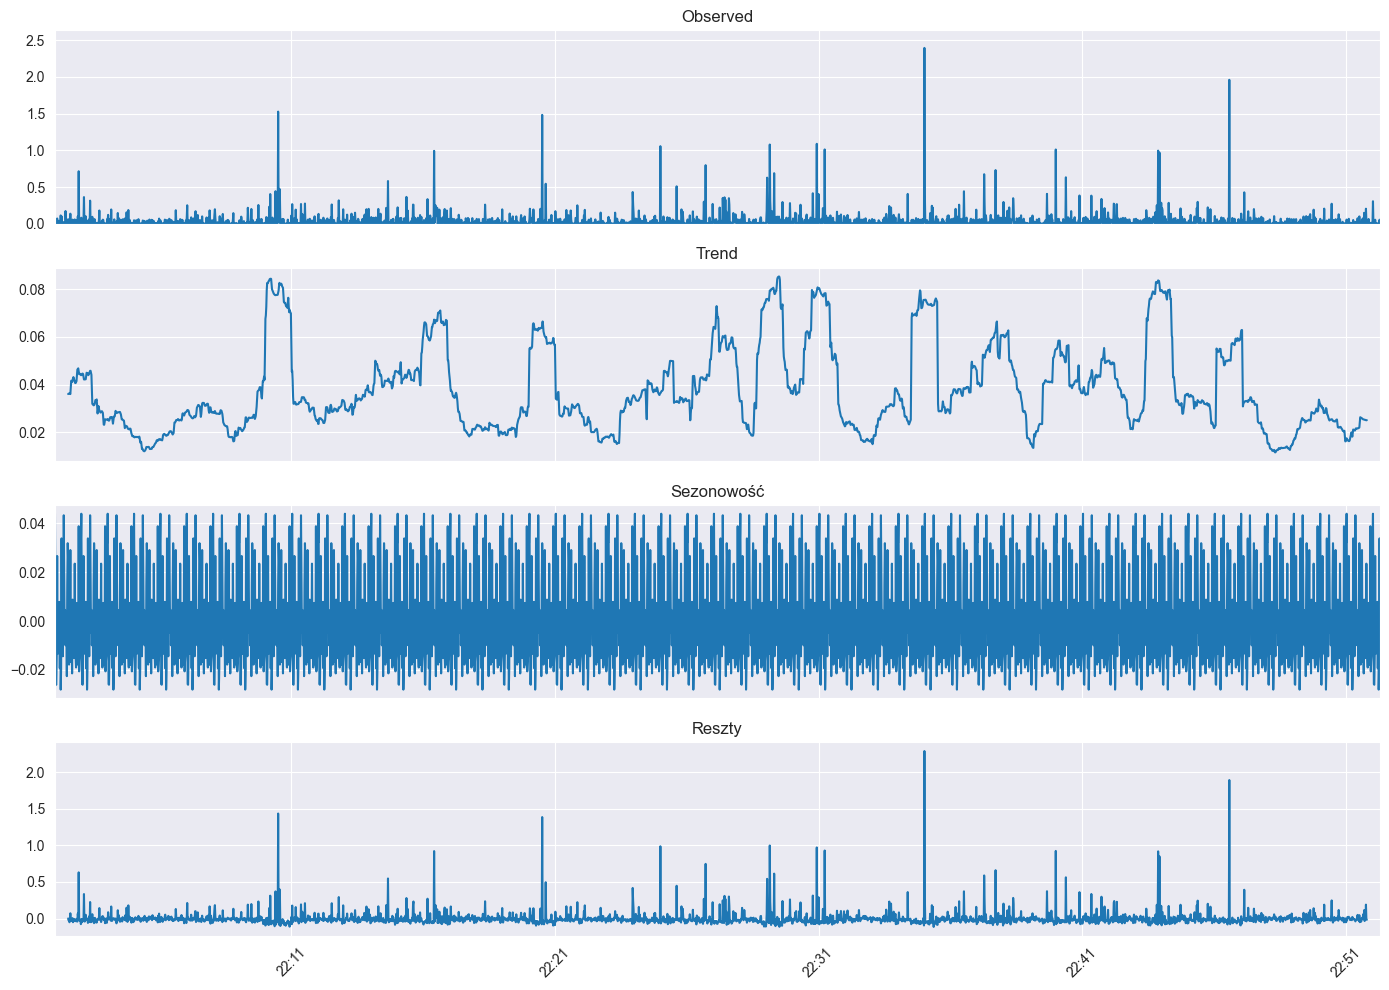

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the data
result = seasonal_decompose(df_grouped["volume"], model="additive", period=60)

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Plot each component
components = ["observed", "trend", "seasonal", "resid"]
titles = ["Observed", "Trend", "Sezonowość", "Reszty"]

for i, (component, title) in enumerate(zip(components, titles)):
    data = getattr(result, component)
    axes[i].plot(data, label=title)
    axes[i].set_title(title)
    # axes[i].legend()

# Set xlim to the range of the data
axes[0].set_xlim(df_grouped.index.min(), df_grouped.index.max())

# Set ylim dynamically based on the observed data
axes[0].set_ylim(
    0, df_grouped["volume"].max() * 1.1
)  # Add padding for aesthetics

# Customize xticks to show every 10 minutes
axes[-1].xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Rotate xtick labels for readability
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout for better display
plt.tight_layout()
plt.show()



In [11]:
from scipy.stats import skew, kurtosis

print(skew(df_grouped["price"]))
print(kurtosis(df_grouped["price"]))

print(skew(df_grouped["volume"]))
print(kurtosis(df_grouped["volume"]))

-0.5563314784425711
-0.7035815591071923
10.09985171689634
151.43586728995956
